# Analysis on Rolling & EWM-weighted Data

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import copy
%matplotlib inline
#import os 
#os.chdir("/Users/michaelyang/Desktop/NYU/2017.Spring/Machine Learning/Project/ml_applications_for_the_nba/")

In [54]:
#import matplotlib
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.figsize'] = [7.5, 4.5]

In [222]:
dataset = ['final_rolling_span20','final_rolling_span40','final_rolling_span80',
           'final_ewm_span50','final_ewm_span100','final_ewm_span200']
current = 1
print 'CURRENT DATASET: data/'+dataset[current]+'.csv'

df = pd.read_csv('data/'+dataset[current]+'.csv').sort_values('GAME_ID')
df = df.dropna()
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE_HOME'])
df['GAME_ID'] = df['GAME_ID'].astype(str)
columns_to_ignore = ['TEAM_ID_HOME','TEAM_ID_AWAY','GAME_DATE_HOME',
                    'GAME_DATE']
columns_to_ignore = columns_to_ignore + [col for col in df.columns if '.1' in col]
df.drop(columns_to_ignore, axis=1, inplace=True)
# Convert IDs to string columns

CURRENT DATASET: data/final_rolling_span40.csv


In [223]:
#df = df.set_index('GAME_ID')

# Define a target column
df['AVG_SPREAD'] = df['PLUS_MINUS_HOME'] - df['PLUS_MINUS_AWAY']
df['ACTUAL_SPREAD'] = df['PLUS_MINUS']

# Remove 'PLUS_MINUS' as a potential feature column'
df.drop('PLUS_MINUS', axis=1, inplace=True)

In [224]:
def select_season(season):
    prefix = {'2012-13':'212', '2013-14':'213', '2014-15':'214',
             '2015-16':'215', '2016-17':'216'}
    return df[df['GAME_ID'].astype(str).str.startswith(prefix[season])]

def select_seasons(seasons):
    result = pd.DataFrame()
    for season in seasons:
        result = pd.concat([result, select_season(season)])
    return result

df_train = select_seasons(['2012-13','2013-14','2014-15'])
df_val = select_seasons(['2015-16'])
df_test = select_seasons(['2016-17'])

In [225]:
# Preprocessing here
from sklearn.preprocessing import StandardScaler

numerical_cols = [c for c in df_train._get_numeric_data().columns]

feature_cols = list(set(numerical_cols) - {'GAME_ID','index_AWAY','index_HOME',
                                           'ACTUAL_SPREAD','PLUS_MINUS',
                                           'TEAM_ID_HOME','TEAM_ID_AWAY'})

scale_cols = [c for c in feature_cols if 'PLUS_MINUS' not in c \
                                          and 'AVG_SPREAD' not in c]

target_cols = ['ACTUAL_SPREAD']

print scale_cols

for col in sorted(scale_cols):
    scl = StandardScaler()
    df_train[col] = scl.fit_transform(df_train[col].as_matrix().reshape(-1,1)) # may want to fit on both validation and train
    # assign val and test
    df_val[col] = scl.transform(df_val[col].as_matrix().reshape(-1,1))
    df_test[col] = scl.transform(df_test[col].as_matrix().reshape(-1,1))

['OPP_PTS_PAINT_AWAY', 'BLK_AWAY', 'PCT_PTS_2PT_AWAY', 'PCT_FGA_2PT_AWAY', 'NET_RATING_HOME', 'PCT_AST_2PM_HOME', 'NET_RATING_AWAY', 'OPP_PTS_PAINT_HOME', 'OPP_FTA_RATE_AWAY', 'AST_PCT_HOME', 'BLKA_AWAY', 'OFF_RATING_AWAY', 'USG_PCT_AWAY', 'PCT_AST_FGM_AWAY', 'OFF_RATING_HOME', 'DEF_RATING_AWAY', 'USG_PCT_HOME', 'OPP_PTS_2ND_CHANCE_HOME', 'PCT_PTS_2PT_MR_HOME', 'OPP_PTS_FB_HOME', 'OPP_OREB_PCT_HOME', 'DEF_RATING_HOME', 'PTS_OFF_TOV_HOME', 'PCT_UAST_3PM_AWAY', 'PCT_PTS_OFF_TOV_AWAY', 'PCT_PTS_3PT_HOME', 'REB_PCT_AWAY', 'PCT_UAST_FGM_HOME', 'BLKA_HOME', 'OPP_OREB_PCT_AWAY', 'OREB_PCT_HOME', 'PCT_UAST_2PM_AWAY', 'AST_PCT_AWAY', 'PTS_FB_AWAY', 'PCT_PTS_FB_HOME', 'PTS_PAINT_HOME', 'PIE_AWAY', 'PCT_PTS_PAINT_HOME', 'AST_TOV_AWAY', 'OPP_EFG_PCT_HOME', 'PFD_HOME', 'OPP_PTS_OFF_TOV_AWAY', 'PTS_2ND_CHANCE_HOME', 'PTS_FB_HOME', 'PTS_PAINT_AWAY', 'PACE_HOME', 'REB_PCT_HOME', 'PCT_PTS_2PT_MR_AWAY', 'TM_TOV_PCT_HOME', 'PCT_PTS_OFF_TOV_HOME', 'PCT_FGA_3PT_AWAY', 'TM_TOV_PCT_AWAY', 'OPP_EFG_PCT_AWAY',

In [226]:
df_train.shape

(3688, 101)

# Metrics
## How do we predict a winner?
1. Simple case: use the current point differential (averaged, either rolling window or EWM) for each team, take the difference.

In [227]:
# CALCULATE BASELINE FOR 0-1 LOSS ===> Predict the outright winner of a game (WIN/LOSS)

def frac_wins_predicted(y_pred, y_actual):
    """Given a point spread prediction and and actual point spread, return the fraction of
       correctly predicted W or L"""
    return (np.sign(y_pred) == np.sign(y_actual)).mean()

In [228]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print "Baseline: using point spreads averaged over the recent games"
print "for each team, home and away:"
print "Fraction of correctly predicted games = ", frac_wins_predicted(df['AVG_SPREAD'], df['ACTUAL_SPREAD'])
print "Mean Sq. Error = ", mean_squared_error(df['AVG_SPREAD'], df['ACTUAL_SPREAD'])

Baseline: using point spreads averaged over the recent games
for each team, home and away:
Fraction of correctly predicted games =  0.646877033182
Mean Sq. Error =  161.269232927


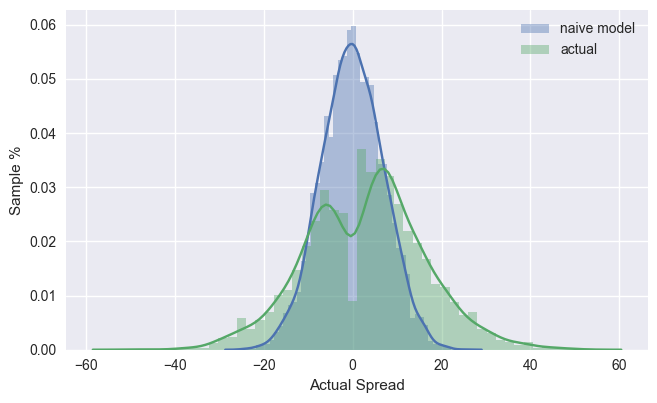

In [229]:
sns.distplot(df['AVG_SPREAD'].dropna(), label='naive model')
sns.distplot(df['ACTUAL_SPREAD'].dropna(), label='actual')
plt.legend()
plt.xlabel("Actual Spread")
plt.ylabel("Sample %")

## Legacy code cells; return to these later

In [230]:
# CALCULATE BASELINE FOR SPREAD LOSS ===> Predict the outright winner of a game (WIN/LOSS)

def betting_metric(y_pred, y_actual):
    # +1 for good outcome, -1 for bad outcome
    '''+1 if predicted > actual and actual is negative,
          or predicted < actual and actual is positive. 
    -1 otherwise.'''
    return (2*(y_pred < y_actual).astype(int) - 1)

# quick test 
betting_metric(np.array([2,3,-3,-2,-1]),np.array([3,2,-2,-3,1]))

array([ 1, -1,  1, -1,  1])

In [231]:
# One metric is fraction correct (accuracy score)
def fraction_correct(y_pred, y_actual):
    '''Given a predicted and actual, check what fraction of betting metrics are postivie'''
    # print y_pred.shape
    counts =  pd.Series(betting_metric(y_pred, y_actual).ravel()).value_counts()
    return float(counts.loc[1])/counts.sum()

# This is the "base modeL"
print betting_metric(df['AVG_SPREAD'], df['PLUS_MINUS_HOME']).mean()
print betting_metric(df['AVG_SPREAD'], df['PLUS_MINUS_HOME']).value_counts()

print fraction_correct(df['AVG_SPREAD'], df['PLUS_MINUS_HOME'])
# Not meaningful, but interesting to see whether AWAY point spread helps.
# print betting_metric(df['PLUS_MINUS_mean_HOME'], df['PLUS_MINUS_HOME']).mean()

-0.0221210149642
-1    3142
 1    3006
dtype: int64
0.488939492518


# Regressions for Predicting Point Spread

## Linear Regression, Lasso

In [293]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train = df_train[feature_cols].as_matrix()
y_train = df_train['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)
X_val = df_val[feature_cols].as_matrix()
y_val = df_val['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)
X_test = df_test[feature_cols].as_matrix()
y_test = df_test['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)


linreg = LinearRegression()
lasso = Lasso(alpha=0.4)

linreg.fit(X_train, y_train.ravel())
lasso.fit(X_train, y_train)


###### LINEAR REGRESSION ######
#print linreg.coef_
print "Linear model"
y_train_pred = linreg.predict(X_train)

# Percentage of times that the Home team is correctly predicted as the winner 
# TRAIN
print "Fraction TRAIN winner predicted correct: ", frac_wins_predicted(y_train_pred, y_train.ravel())
print "TRAIN Mean Sq. Error = ", mean_squared_error(y_train_pred, y_train)

# VALIDATE
print "Fraction VALIDATE winner predicted correct: ", frac_wins_predicted(linreg.predict(X_val), y_val.ravel())
print "VALIDATE Mean Sq. Error = ", mean_squared_error(linreg.predict(X_val), y_val)

# TEST
print "Fraction TEST winner predicted correct: ", frac_wins_predicted(linreg.predict(X_test), y_test.ravel())
print "TEST Mean Sq. Error = ", mean_squared_error(linreg.predict(X_test), y_test)

###### LASSO ######
print ""
print "Lasso"
y_train_pred = lasso.predict(X_train)

# TRAIN
print "Fraction TRAIN winner predicted correct: ", frac_wins_predicted(y_train_pred, y_train.ravel())
print "TRAIN Mean Sq. Error = ", mean_squared_error(lasso.predict(X_val), y_val)

# VALIDATE
print "Fraction VALIDATE winner predicted correct: ", frac_wins_predicted(lasso.predict(X_val), y_val.ravel())
print "VALIDATE Mean Sq. Error = ", mean_squared_error(lasso.predict(X_val), y_val)

# TEST
print "Fraction TEST winner predicted correct: ", frac_wins_predicted(lasso.predict(X_test), y_test.ravel())
print "TEST Mean Sq. Error = ", mean_squared_error(lasso.predict(X_test), y_test), "\n"

print "Fraction of zero coefficients: ", np.sum(lasso.coef_==0).astype(float) / lasso.coef_.shape[0]
X_val.shape

Linear model
Fraction TRAIN winner predicted correct:  0.672180043384
TRAIN Mean Sq. Error =  143.980048963
Fraction VALIDATE winner predicted correct:  0.688617886179
VALIDATE Mean Sq. Error =  146.887815125
Fraction TEST winner predicted correct:  0.626829268293
TEST Mean Sq. Error =  169.129555683

Lasso
Fraction TRAIN winner predicted correct:  0.657809110629
TRAIN Mean Sq. Error =  140.27892677
Fraction VALIDATE winner predicted correct:  0.685365853659
VALIDATE Mean Sq. Error =  140.27892677
Fraction TEST winner predicted correct:  0.640650406504
TEST Mean Sq. Error =  163.101778361 

Fraction of zero coefficients:  0.948453608247


(1230L, 97L)

In [280]:
print X_train.shape 
print y_train.shape 
print X_val.shape 
print y_val.shape 
print X_test.shape 
print y_test.shape 

(3688L, 97L)
(3688L, 1L)
(1230L, 97L)
(1230L, 1L)
(1230L, 97L)
(1230L, 1L)


# Random Forest

In [233]:
#y_train_cat = np.concatenate([y_train, np.sign(y_train)], axis=1)

Random Forest
TRAIN Percent wins correct: 0.906453362256
Mean Sq. Error =  30.3706507592
VALIDATE Percent wins correct: 0.647154471545
Mean Sq. Error =  167.29504878
TEST Percent wins correct: 0.59512195122
Mean Sq. Error =  189.668626016


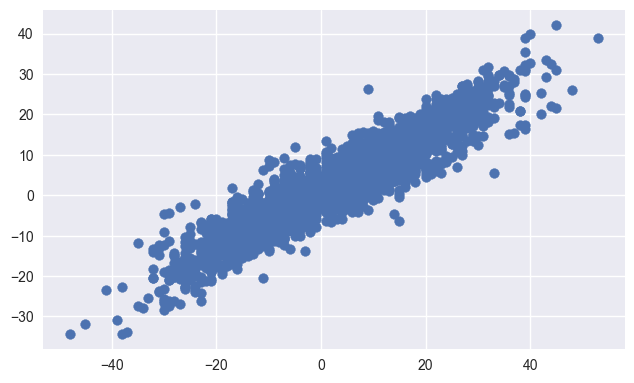

In [234]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor() # todo: hyperparameter search...

rf.fit(X_train, y_train.ravel())
print "Random Forest"
y_train_pred = rf.predict(X_train)

# TRAIN
print "TRAIN Percent wins correct:", frac_wins_predicted(y_train_pred, y_train.ravel())
print "Mean Sq. Error = ", mean_squared_error(y_train_pred, y_train.ravel())

# VALIDATE
print "VALIDATE Percent wins correct:", frac_wins_predicted(rf.predict(X_val), y_val.ravel())
print "Mean Sq. Error = ", mean_squared_error(rf.predict(X_val), y_val.ravel())

# TEST
print "TEST Percent wins correct:", frac_wins_predicted(rf.predict(X_test), y_test.ravel())
print "Mean Sq. Error = ", mean_squared_error(rf.predict(X_test), y_test.ravel())

#print fraction_correct(y_train_pred, y_train)
plt.scatter(y_train.ravel(), y_train_pred.ravel())

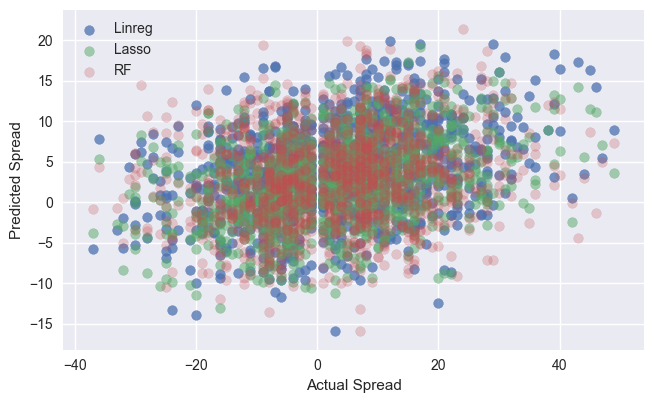

In [235]:
plt.scatter(y_test, linreg.predict(X_test), alpha=0.75, label="Linreg")
plt.scatter(y_test, lasso.predict(X_test), alpha = 0.5,label="Lasso")
plt.scatter(y_test, rf.predict(X_test), alpha = 0.25,label="RF")
plt.legend()
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')

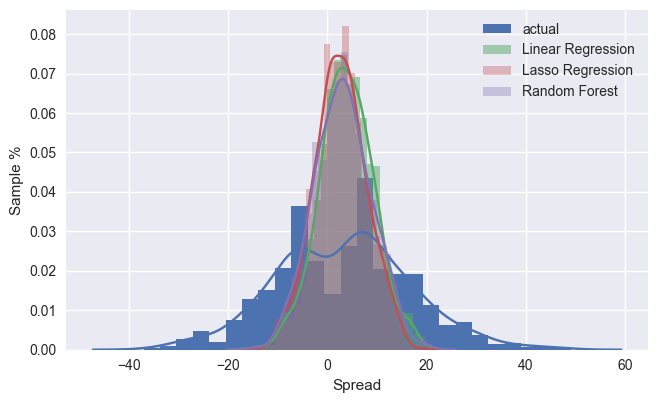

In [236]:
sns.distplot(y_test, label='actual',hist_kws={"alpha": 1.})

sns.distplot(linreg.predict(X_test),label='Linear Regression',hist_kws={"alpha": 0.50})
sns.distplot(lasso.predict(X_test),label='Lasso Regression',hist_kws={"alpha": 0.35})
sns.distplot(rf.predict(X_test),label='Random Forest',hist_kws={"alpha": 0.35})

plt.legend()
plt.xlabel("Spread")
plt.ylabel("Sample %")

In [237]:
# Logistic regression on W/L
from sklearn.linear_model import LogisticRegression
LogR = LogisticRegression()
LogR.fit(X_train, np.sign(y_train).reshape(-1))
print "Predicted (training) wins correct: ", frac_wins_predicted(LogR.predict(X_train), y_train.ravel())
print "Predicted (validation) wins correct: ", frac_wins_predicted(LogR.predict(X_val), y_val.ravel())
print "Predicted (test) wins correct: ", frac_wins_predicted(LogR.predict(X_test), y_test.ravel())

np.array([LogR.predict(X_train)==np.sign(y_train).reshape(-1)]).astype(int).mean()

Predicted (training) wins correct:  0.680314533623
Predicted (validation) wins correct:  0.673170731707
Predicted (test) wins correct:  0.631707317073


0.68031453362255967

In [238]:
# give a range which the prediction can be away from actual
def evaluate_prediction(y_pred,y_actual):
    
    delta = 10 # the range
    score = np.logical_and((y_pred < y_actual),\
    (y_pred > y_actual-delta)).astype(float)
    
    return sum(score)/len(score)
# evaluate_prediction(np.array([-1,-2,-5]),np.array([11,3,-10])) test

# XGBoost Regression

In [239]:
import xgboost as xgb
from  functools import partial

dtrain = xgb.DMatrix(X_train, (y_train))
param = {'max_depth': 4, 'silent': 1}
num_round = 150

def learn_rate(n,t_n):
    return 1/(np.sqrt(n+.1))

def hinge(preds, dtrain):
    labels = dtrain.get_label()
    m = len(labels)
    a =  (labels <= preds).astype(int)
    # print preds
    # print(a[10:30])
    return a*np.ones(m), np.zeros(m)

def log(preds,dtrain):
    labels = dtrain.get_label()
    m = labels*preds
    return 1/(1+np.exp(m)) , 1/(np.exp(-m/2)+np.exp(m/2))**2

def softmax(preds,dtrain):
    labels = dtrain.get_label()
    m = labels - preds
    return 1/(np.exp(-m/2)+np.exp(m/2))**2, \
            2/(np.exp(-2*m/3)+np.exp(m/3))**3 \
                - 1/(np.exp(-m/2)+np.exp(m/2))**2

def skewed_sq(preds, dtrain,skewness,flat_region):
    labels = dtrain.get_label()
    b = skewness
    spread = flat_region
    a = (1)*(preds>labels) + \
            b*(preds<= labels-spread)
    return a*(preds - labels), a*np.ones(len(labels))

In [240]:
xgb_reg = xgb.XGBRegressor(max_depth=4, n_estimators = 50, reg_alpha=0.5, reg_lambda=0.02)
xgb_reg.fit(X_train, y_train)

print 'XGBoost'
y_train_predict = xgb_reg.predict(X_train)

# TRAIN
print "TRAIN Percent wins correct:", frac_wins_predicted(y_train_predict, y_train.ravel())
print "Mean Sq. Error = ", mean_squared_error(y_train_predict, y_train.ravel())

# VALIDATE
print "VALIDATE Percent wins correct:", frac_wins_predicted(xgb_reg.predict(X_val), y_val.ravel())
print "Mean Sq. Error = ", mean_squared_error(xgb_reg.predict(X_val), y_val.ravel())

# TEST
print "TEST Percent wins correct:", frac_wins_predicted(xgb_reg.predict(X_test), y_test.ravel())
print "Mean Sq. Error = ", mean_squared_error(xgb_reg.predict(X_test), y_test.ravel())

XGBoost
TRAIN Percent wins correct: 0.738340563991
Mean Sq. Error =  112.098883142
VALIDATE Percent wins correct: 0.678861788618
Mean Sq. Error =  149.873969012
TEST Percent wins correct: 0.620325203252
Mean Sq. Error =  175.200650977


In [241]:
xgb_cls = xgb.XGBClassifier()
xgb_cls.fit(X_train, (1+np.sign(y_train).ravel())/2)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [242]:
print "XGBoost Classifier"
print "TRAIN % of correctly predicted wins = ", (xgb_cls.predict(X_train).astype(int) == 0.5*(1+np.sign(y_train).ravel())).mean()
print "VALIDATE % of correctly predicted wins = ", (xgb_cls.predict(X_val).astype(int) == 0.5*(1+np.sign(y_val).ravel())).mean()
print "TEST % of correctly predicted wins = ", (xgb_cls.predict(X_test).astype(int) == 0.5*(1+np.sign(y_test).ravel())).mean()
print "=============="

XGBoost Classifier
TRAIN % of correctly predicted wins =  0.758134490239
VALIDATE % of correctly predicted wins =  0.674796747967
TEST % of correctly predicted wins =  0.634959349593


In [243]:
sorted(zip(xgb_reg.feature_importances_, feature_cols), key=lambda x: x[0], reverse=True)[:10]

[(0.064421669, 'OPP_PTS_PAINT_AWAY'),
 (0.061493412, 'AVG_SPREAD'),
 (0.030746706, 'BLK_AWAY'),
 (0.021961933, 'OPP_PTS_OFF_TOV_AWAY'),
 (0.020497805, 'PCT_PTS_2PT_AWAY'),
 (0.020497805, 'PCT_PTS_2PT_MR_HOME'),
 (0.020497805, 'OPP_OREB_PCT_HOME'),
 (0.020497805, 'PCT_PTS_FT_HOME'),
 (0.019033674, 'NET_RATING_HOME'),
 (0.019033674, 'OPP_PTS_FB_HOME')]

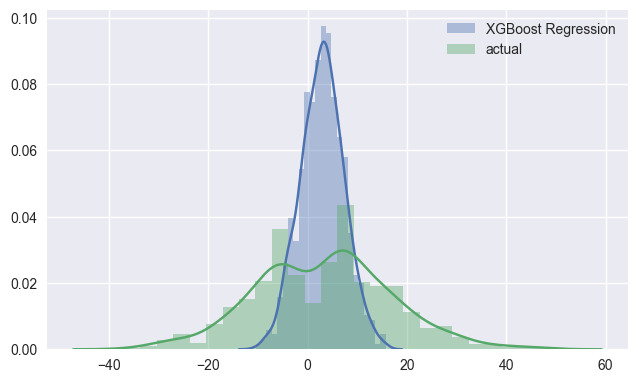

In [244]:
sns.distplot(xgb_reg.predict(X_test), label='XGBoost Regression')
sns.distplot(y_test, label='actual')
plt.legend()

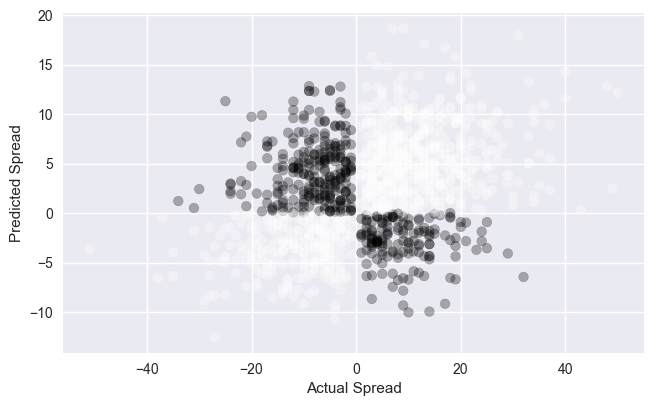

In [245]:
right_wrong = (np.sign(xgb_reg.predict(X_val)) == np.sign(y_val.ravel()))

plt.scatter(y_val.ravel(), xgb_reg.predict(X_val),
           c=(~right_wrong).astype(int), alpha=0.3)

plt.xlabel("Actual Spread")
plt.ylabel("Predicted Spread")

Mean Sq. Error =  146.887815125


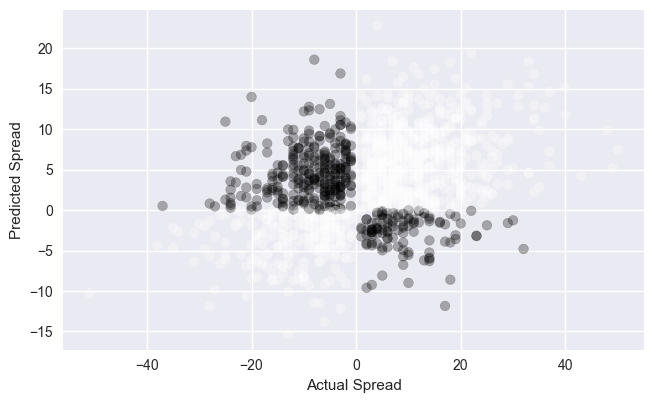

In [246]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
right_wrong = (np.sign(linreg.predict(X_val).ravel()) == np.sign(y_val.ravel()))

plt.scatter(y_val.ravel(), linreg.predict(X_val).ravel(),
           c=(~right_wrong).astype(int), alpha=0.3)
plt.xlabel("Actual Spread")
plt.ylabel("Predicted Spread")

print "Mean Sq. Error = ", mean_squared_error(linreg.predict(X_val), y_val)

## Spread Loss: Construct Train, Validate & Test sets

In [247]:
linreg_s = LinearRegression()
lasso_s = Lasso(alpha=0.4)

linreg_s.fit(X_train, y_train)
lasso_s.fit(X_train, y_train)

print 'LinReg (SPREAD) TRAIN:', fraction_correct(linreg_s.predict(X_train), y_train.ravel())
print 'Lasso (SPREAD) TRAIN:', fraction_correct(lasso_s.predict(X_train), y_train.ravel()), '\n'

print 'LinReg (SPREAD) VALIDATE:', fraction_correct(linreg_s.predict(X_val), y_val.ravel())
print 'LinReg (SPREAD) TEST:', fraction_correct(linreg_s.predict(X_test), y_test.ravel()), '\n'

print 'Lasso (SPREAD) VALIDATE:', fraction_correct(lasso_s.predict(X_val), y_val.ravel())
print 'Lasso (SPREAD) TEST:', fraction_correct(lasso_s.predict(X_test), y_test.ravel())

LinReg (SPREAD) TRAIN: 0.506752200371
Lasso (SPREAD) TRAIN: 0.506236442516 

LinReg (SPREAD) VALIDATE: 0.491980963712
LinReg (SPREAD) TEST: 0.48162601626 

Lasso (SPREAD) VALIDATE: 0.49756097561
Lasso (SPREAD) TEST: 0.518699186992


In [248]:
# RANDOM FOREST REGRESSION (SPREAD LOSS)
rf_spread = RandomForestRegressor()
rf_spread.fit(X_train, y_train.ravel())

print 'RandomForest (SPREAD) VALIDATE:', fraction_correct(rf_spread.predict(X_val), y_val)
print 'RandomForest (SPREAD) TEST:', fraction_correct(rf_spread.predict(X_test), y_test)

RandomForest (SPREAD) VALIDATE: 0.487519994712
RandomForest (SPREAD) TEST: 0.497737457862


In [249]:
# XGBoost REGRESSION (SPREAD lOSS)
xgb_regS = xgb.XGBRegressor(max_depth=4, n_estimators = 50, reg_alpha=0.5, reg_lambda=0.02)
xgb_regS.fit(X_train, y_train)

print 'XGBoost (SPREAD) VALIDATE:', fraction_correct(xgb_regS.predict(X_val), y_val)
print 'XGBoost (SPREAD) TEST:', fraction_correct(xgb_regS.predict(X_test), y_test)

XGBoost (SPREAD) VALIDATE: 0.51581003371
XGBoost (SPREAD) TEST: 0.509468570295


In [250]:
# LOGISTIC REGRESSION (SPREAD LOSS)
LogR_s = LogisticRegression()
LogR_s.fit(X_train,y_train)

print 'LogReg (SPREAD) VALIDATE:', fraction_correct(LogR_s.predict(X_val), y_val.ravel())
print 'LogReg (SPREAD) TEST:', fraction_correct(LogR_s.predict(X_test), y_test.ravel())

LogReg (SPREAD) VALIDATE: 0.505691056911
LogReg (SPREAD) TEST: 0.514634146341


TRAIN c =  0.01 0.675704989154
VAL c =  0.01 0.680487804878
TEST c =  0.01 0.644715447154

TRAIN c =  0.1 0.678958785249
VAL c =  0.1 0.664227642276
TEST c =  0.1 0.652845528455

TRAIN c =  1 0.68194143167
VAL c =  1 0.670731707317
TEST c =  1 0.633333333333

TRAIN c =  10 0.469902386117
VAL c =  10 0.463414634146
TEST c =  10 0.50487804878



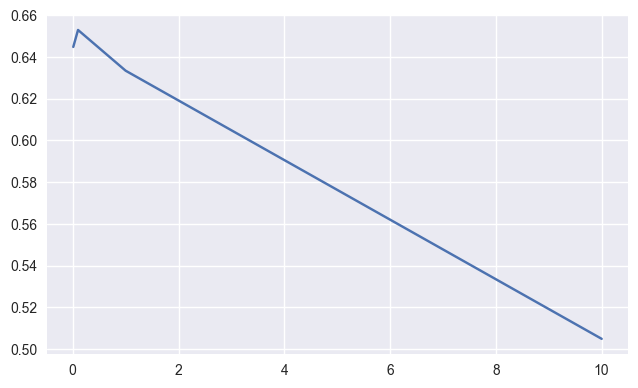

In [251]:
# SVM on W/L
from sklearn.svm import LinearSVC as svm
scores = []
cs = [0.01,0.1,1,10]
for c in cs:
    SVM = svm(C=c,penalty='l2',loss='hinge')
    SVM.fit(X_train, np.sign(y_train).reshape(-1)) # y_train is the actual spread, np.sign(y_train) => home team win=1, loss=-1
    num_correct_train = (SVM.predict(X_train) == np.sign(y_train).reshape(-1)).astype(int).mean()
    print 'TRAIN c = ', c, num_correct_train
    num_correct_val = (SVM.predict(X_val) == np.sign(y_val).reshape(-1)).astype(int).mean()
    print 'VAL c = ', c, num_correct_val
    num_correct_test = (SVM.predict(X_test) == np.sign(y_test).ravel()).astype(int).mean()
    print 'TEST c = ', c, num_correct_test
    print ''
    scores.append(num_correct_test)
plt.plot(cs, scores)

In [252]:
SVM.coef_.shape

(1L, 97L)

In [253]:
sorted(zip(df_train.drop('AVG_SPREAD', axis=1).columns.values, SVM.coef_.ravel()), key=lambda x: np.abs(x[1]), 
       reverse=True)[:10]

[('PTS_PAINT_AWAY', -1.2956653356168375),
 ('PTS_OFF_TOV_AWAY', 1.2652417159798837),
 ('PCT_UAST_2PM_HOME', 1.1281915687950179),
 ('DREB_PCT_AWAY', 1.0202361640482613),
 ('TM_TOV_PCT_AWAY', -0.85429039435204046),
 ('PCT_PTS_PAINT_HOME', -0.81586261329204068),
 ('PCT_AST_3PM_HOME', 0.8038800581188591),
 ('PCT_AST_2PM_HOME', -0.73588153415706503),
 ('PTS_FB_AWAY', 0.73184465154532519),
 ('AST_PCT_HOME', -0.69986527221197603)]

52


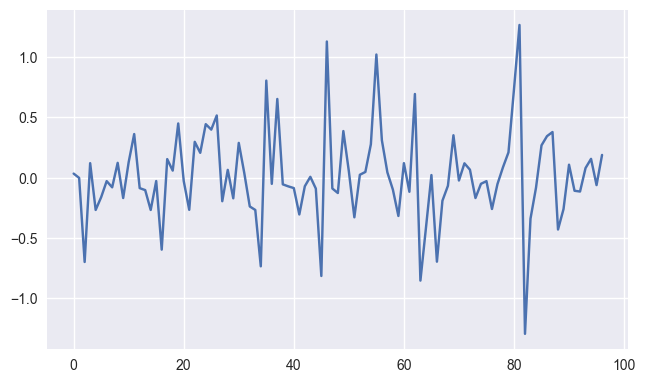

In [254]:
# DETERMINE SPARSITY OF WEIGHT VECTOR
# Roughly how many non-support vectors
#plt.plot(np.arange(0,len(SVM.coef_.reshape(-1)),1),SVM.coef_.reshape(-1))
plt.plot(SVM.coef_.ravel())
#plt.hist(SVM.coef_.ravel())
# number of features that are zeros
print sum(SVM.coef_.reshape(-1) < 10**-5)

In [255]:
# Identifying the important features based on weight lenghth
#significant = np.where((np.abs(SVM.coef_.reshape(-1)) > 0.1))
#print np.where((np.abs(SVM.coef_.reshape(-1)) > 0.1))
# the support vectors
#SVM.coef_[significant[0]]

In [256]:
important_features = df_train[feature_cols].keys()[significant[0]]
# print important_features[important_features.str.contains("HOME")]
# print important_features[important_features.str.contains("AWAY")]
print important_features

Index([u'OPP_PTS_PAINT_AWAY', u'PCT_PTS_2PT_AWAY', u'PCT_FGA_2PT_AWAY',
       u'NET_RATING_HOME', u'PCT_AST_2PM_HOME', u'NET_RATING_AWAY',
       u'OPP_PTS_PAINT_HOME', u'OPP_FTA_RATE_AWAY', u'PCT_AST_FGM_AWAY',
       u'OFF_RATING_HOME', u'DEF_RATING_AWAY', u'PCT_PTS_2PT_MR_HOME',
       u'OPP_OREB_PCT_HOME', u'DEF_RATING_HOME', u'PCT_UAST_3PM_AWAY',
       u'PCT_PTS_OFF_TOV_AWAY', u'PCT_PTS_3PT_HOME', u'REB_PCT_AWAY',
       u'OPP_OREB_PCT_AWAY', u'PCT_UAST_2PM_AWAY', u'AST_PCT_AWAY',
       u'PTS_FB_AWAY', u'PCT_PTS_FB_HOME', u'PTS_PAINT_HOME', u'PIE_AWAY',
       u'PCT_PTS_PAINT_HOME', u'AST_TOV_AWAY', u'OPP_EFG_PCT_HOME',
       u'PFD_HOME', u'PTS_2ND_CHANCE_HOME', u'PTS_FB_HOME', u'PTS_PAINT_AWAY',
       u'REB_PCT_HOME', u'PCT_PTS_2PT_MR_AWAY', u'TM_TOV_PCT_HOME',
       u'OPP_EFG_PCT_AWAY', u'EFG_PCT_AWAY', u'PCT_AST_3PM_AWAY',
       u'OREB_PCT_AWAY', u'OPP_TOV_PCT_AWAY', u'PCT_PTS_2PT_HOME',
       u'EFG_PCT_HOME', u'PCT_AST_3PM_HOME', u'PCT_PTS_PAINT_AWAY',
       u'PACE_AW

In [257]:
# Identifying which teams we are getting wrong/right consistantly

from collections import Counter
games_wrong = df_train[(SVM.predict(X_train) != np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
games_wrong_dict = games_wrong.to_dict()
for key,value in games_wrong_dict.items():
    games_wrong_dict[key] = value[0:3]
games_wrong_dict = Counter(games_wrong_dict).most_common()
dictw = {}; temp = ''
for v,k in games_wrong_dict:
    if (temp != k):
        dictw[k] = 0
        temp = k
    dictw[temp] += 1
games_wrong_dict = dictw

In [258]:
games_right = df_train[(SVM.predict(X_train) == np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
games_right_dict = games_right.to_dict()
for key,value in games_right_dict.items():
    games_right_dict[key] = value[0:3]
games_right_dict = Counter(games_right_dict).most_common()
dictr = {}; temp = ''
for v,k in games_right_dict:
    if (temp != k):
        dictr[k] = 0
        temp = k
    dictr[temp] += 1
games_right_dict = dictr
# games_right.shape
# df_train[numerical_cols].keys()

In [259]:
games_wrong_dict
# sorted by number of wrong games
sorted(games_wrong_dict.items(), key=lambda x: x[1],reverse=True)

[('LAC', 81),
 ('PHI', 78),
 ('MIN', 76),
 ('MIL', 75),
 ('MIA', 74),
 ('ORL', 73),
 ('OKC', 73),
 ('TOR', 72),
 ('CLE', 70),
 ('UTA', 68),
 ('LAL', 68),
 ('MEM', 68),
 ('BOS', 65),
 ('DET', 65),
 ('NYK', 64),
 ('CHA', 64),
 ('DAL', 63),
 ('DEN', 61),
 ('SAC', 61),
 ('HOU', 61),
 ('PHX', 61),
 ('ATL', 60),
 ('WAS', 59),
 ('GSW', 57),
 ('BKN', 57),
 ('IND', 57),
 ('CHI', 53),
 ('SAS', 52),
 ('POR', 48),
 ('NOP', 44),
 ('NOH', 27)]

In [260]:
games_right_dict
#sorted by number of right games
sorted(games_right_dict.items(), key=lambda x: x[1],reverse=True)

[('POR', 75),
 ('SAS', 71),
 ('CHI', 70),
 ('GSW', 66),
 ('BKN', 66),
 ('IND', 66),
 ('WAS', 64),
 ('ATL', 62),
 ('DEN', 62),
 ('SAC', 62),
 ('HOU', 62),
 ('PHX', 62),
 ('DAL', 60),
 ('NYK', 59),
 ('CHA', 59),
 ('DET', 58),
 ('BOS', 57),
 ('UTA', 55),
 ('LAL', 55),
 ('MEM', 55),
 ('CLE', 53),
 ('TOR', 51),
 ('ORL', 50),
 ('OKC', 50),
 ('MIA', 49),
 ('MIL', 48),
 ('MIN', 47),
 ('PHI', 45),
 ('LAC', 42),
 ('NOP', 38),
 ('NOH', 14)]

In [261]:
# look at those team separately wrong/right
team_wrong = df_train[(SVM.predict(X_train) != np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
ind_w = team_wrong[team_wrong.str[0:3].str.contains("SAC")].index

In [262]:
team_right = df_train[(SVM.predict(X_train) == np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
ind_r = team_right[team_right.str[0:3].str.contains("SAS")].index
print ind_r

Int64Index([  13,   34,   46,  136,  238,  263,  277,  386,  401,  417,  431,
             521,  575,  677,  857,  922,  943,  981, 1066, 1081, 1185, 1224,
            1311, 1399, 1423, 1437, 1643, 1680, 1723, 1818, 1912, 1933, 2088,
            2117, 2143, 2161, 2194, 2297, 2321, 2352, 2415, 2450, 2461, 2650,
            2750, 2781, 2798, 2834, 2873, 2913, 2940, 2958, 3004, 3054, 3069,
            3107, 3122, 3148, 3198, 3216, 3365, 3380, 3390, 3408, 3445, 3487,
            3530, 3543, 3593, 3609, 3627],
           dtype='int64')


In [263]:
df_train.head()

,GAME_ID,MATCHUP_HOME,AST_PCT_HOME,AST_RATIO_HOME,AST_TOV_HOME,DEF_RATING_HOME,DREB_PCT_HOME,EFG_PCT_HOME,NET_RATING_HOME,OFF_RATING_HOME,...,PCT_PTS_FB_AWAY,PCT_PTS_FT_AWAY,PCT_PTS_OFF_TOV_AWAY,PCT_PTS_PAINT_AWAY,PCT_UAST_2PM_AWAY,PCT_UAST_3PM_AWAY,PCT_UAST_FGM_AWAY,PLUS_MINUS_AWAY,AVG_SPREAD,ACTUAL_SPREAD
0,21200001,CLE vs. WAS,2.047196,1.644819,1.582865,0.336168,1.422973,1.263432,0.705092,1.276314,...,-1.133973,0.399770,-0.822213,-0.433024,-0.083806,0.826710,-0.223439,0.375,2.775,10
1,21200002,MIA vs. BOS,-1.565347,-1.048597,-0.587643,2.432562,0.978852,0.062493,-1.717302,-0.283025,...,-0.138232,0.900413,-0.982556,-0.373314,-0.384652,-0.060701,-0.748278,-1.550,-7.500,13
2,21200003,LAL vs. DAL,-0.550035,0.436578,1.496560,1.497518,1.256933,2.148985,0.570303,2.093773,...,0.113236,-0.892120,-0.550259,-0.362900,-0.283787,-0.988129,-0.689885,0.850,1.875,-8
3,21200004,TOR vs. IND,-1.985620,-1.792301,-1.328321,0.846887,3.303401,-0.312379,-0.318448,0.289793,...,0.758026,-0.122453,-1.507601,0.181430,0.501560,-0.187783,0.366049,-8.550,8.200,-2
4,21200005,PHI vs. DEN,-0.567373,0.217710,0.887272,1.015088,1.131392,0.988451,0.173080,1.121175,...,-1.460052,-0.892120,-0.393059,-2.426354,0.457833,0.842933,-0.045480,-1.075,1.800,9


In [264]:
print df_train[feature_cols].ix[ind_r]

      OPP_PTS_PAINT_AWAY  BLK_AWAY  PCT_PTS_2PT_AWAY  PCT_FGA_2PT_AWAY  \
13             -0.493054  1.547555         -0.515067         -0.642764   
34             -0.854586  0.042548         -0.453114         -0.611965   
46              1.245741 -0.198253         -0.039243         -0.583915   
136            -0.406975 -0.408954         -1.083501         -1.677294   
238            -0.579133  0.644551         -0.440340         -0.145024   
263            -0.355328  2.239859         -0.052655         -0.580065   
277             1.073583  1.126153         -1.286604         -1.680594   
386             0.763699 -0.198253         -0.594264         -0.882009   
401             0.161146  0.584351         -0.148459          0.122821   
417             0.780915  0.283349         -0.441617         -0.369419   
431             0.625972  0.403750         -1.545274         -1.699843   
521             0.333304  0.764952         -1.379214         -1.087155   
575            -1.026744  0.584351    

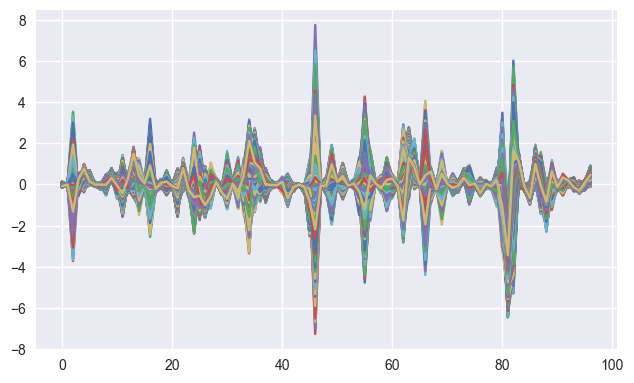

In [265]:
# looking at the score associate with each features in those games
# Calculate the features that are most common in those games to have high scores
WAS_features_w = df_train[feature_cols].ix[ind_w].as_matrix()
WAS_features_r = df_train[feature_cols].ix[ind_r].as_matrix()

SVM_coef = SVM.coef_.reshape(-1)
feature_score_w = WAS_features_w*SVM_coef
feature_score_r = WAS_features_r*SVM_coef
counts = {}
for i in range(0,WAS_features_r.shape[0]):
    for j in range(0,WAS_features_w.shape[0]):
        plt.plot(feature_score_w[j,:]-feature_score_r[i,:])
        where = np.where(np.absolute(feature_score_w[j,:]-feature_score_r[i,:]) > 0.3)
        for k in range(0,len(where[0])):
           if where[0][k] not in counts.keys():
             counts[where[0][k]] = 1 
           else:
             counts[where[0][k]] +=1
counts
list1 = (sorted(counts.items(), key=lambda x: x[1],reverse=True))
cd = [k  for (k,v) in list1]

df_train[feature_cols].ix[ind_r]
plt.show()

In [266]:
df_train[feature_cols].ix[ind_r]

,OPP_PTS_PAINT_AWAY,BLK_AWAY,PCT_PTS_2PT_AWAY,PCT_FGA_2PT_AWAY,NET_RATING_HOME,PCT_AST_2PM_HOME,NET_RATING_AWAY,OPP_PTS_PAINT_HOME,OPP_FTA_RATE_AWAY,AST_PCT_HOME,...,PCT_PTS_FT_AWAY,PCT_UAST_3PM_HOME,PTS_OFF_TOV_AWAY,OPP_TOV_PCT_HOME,OPP_PTS_2ND_CHANCE_AWAY,PCT_FGA_3PT_HOME,PCT_PTS_3PT_AWAY,BLK_HOME,OPP_PTS_FB_AWAY,FTA_RATE_HOME
13,-0.493054,1.547555,-0.515067,-0.642764,-0.950957,-0.341652,1.082380,0.208582,-1.321129,0.135856,...,-0.766959,-0.271092,0.520518,-1.374592,-0.623381,0.339297,0.840795,-1.152677,-0.806404,-0.383736
34,-0.854586,0.042548,-0.453114,-0.611965,-0.926666,-0.144708,0.671706,0.071268,0.330488,0.295366,...,0.237205,-0.271092,-0.698965,-1.226730,-0.459963,0.301452,0.340645,-1.182423,-1.464273,-0.417573
46,1.245741,-0.198253,-0.039243,-0.583915,-0.913806,-0.063034,-1.609817,0.002611,-0.131577,0.340444,...,0.017095,-0.192766,-1.244145,-1.190244,0.590581,0.257573,0.026714,-1.093186,0.432838,-0.421892
136,-0.406975,-0.408954,-1.083501,-1.677294,-0.749964,0.097997,-0.459074,0.174253,-0.555724,0.350847,...,-1.210057,0.082196,-0.584190,-1.065426,-0.646727,0.061765,1.597625,-0.855221,1.228401,-0.570918
238,-0.579133,0.644551,-0.440340,-0.145024,-0.272724,0.091046,0.930278,0.706344,-0.340564,0.140017,...,-0.152664,0.061382,0.276622,-1.036622,-1.487162,-0.170792,0.504216,-0.795729,-1.188886,-0.525562
263,-0.355328,2.239859,-0.052655,-0.580065,-0.155082,0.033121,0.347539,0.706344,0.417787,0.090777,...,-1.310761,0.061382,0.721374,-0.884919,-0.133127,-0.105522,0.621861,-0.765984,-1.387777,-0.462928
277,1.073583,1.126153,-1.286604,-1.680594,-0.077923,0.287411,1.196931,0.654852,-1.199440,0.321026,...,-0.679202,-0.046522,1.338289,-1.042383,0.450508,-0.119234,1.561136,-0.736238,1.763876,-0.421892
386,0.763699,-0.198253,-0.594264,-0.882009,0.362166,0.740382,-1.011393,0.105596,-0.488707,0.971547,...,-0.992824,-0.514833,-1.100677,-0.737057,1.524398,0.110031,1.020723,-0.141325,-0.332126,-0.659470
401,0.161146,0.584351,-0.148459,0.122821,0.462662,0.762393,0.304761,0.139925,0.516549,0.997207,...,-0.263438,-0.593159,0.276622,-0.658326,1.454362,0.174204,0.260747,-0.111580,0.096254,-0.588916
417,0.780915,0.283349,-0.441617,-0.369419,0.717475,0.820318,-0.369714,0.054104,1.998859,1.162959,...,0.552265,-0.784865,0.018378,-0.491261,0.403818,0.199982,0.195318,-0.141325,-0.286228,-0.511884


In [267]:
print list1
print cd
print type(cd)

[(81, 4331), (63, 4152), (83, 4007), (64, 3967), (13, 3946), (88, 3809), (82, 3786), (22, 3721), (85, 3673), (55, 3650), (46, 3610), (9, 3609), (73, 3609), (4, 3547), (80, 3398), (34, 3367), (62, 3339), (35, 3320), (2, 3255), (45, 3202), (66, 3181), (16, 3136), (86, 3135), (26, 3128), (36, 3048), (41, 2791), (24, 2594), (11, 2555), (25, 2477), (69, 2436), (49, 2389), (96, 2368), (87, 2361), (21, 2078), (54, 2003), (59, 1989), (56, 1959), (14, 1937), (33, 1937), (30, 1898), (5, 1872), (74, 1869), (76, 1812), (89, 1792), (51, 1750), (32, 1715), (27, 1378), (79, 1252), (67, 1195), (19, 1185), (29, 1091), (94, 1061), (37, 1055), (23, 724), (48, 596), (10, 555), (71, 311), (3, 297), (8, 297), (42, 277), (60, 273), (44, 243), (91, 206), (17, 202), (12, 167), (84, 164), (58, 136), (72, 78), (40, 71), (93, 18), (90, 12)]
[81, 63, 83, 64, 13, 88, 82, 22, 85, 55, 46, 9, 73, 4, 80, 34, 62, 35, 2, 45, 66, 16, 86, 26, 36, 41, 24, 11, 25, 69, 49, 96, 87, 21, 54, 59, 56, 14, 33, 30, 5, 74, 76, 89, 51

In [268]:
print important_features[important_features.str.contains("HOME")]
print important_features[important_features.str.contains("AWAY")]
# the features that have hightest frequency in those games
#df_train[feature_cols].keys()[cd[0:20]]
df_val[feature_cols].keys()[cd[0:20]]
#df_train[feature_cols][df_val[feature_cols].keys()[cd[0:20]]]

Index([u'NET_RATING_HOME', u'PCT_AST_2PM_HOME', u'OPP_PTS_PAINT_HOME',
       u'OFF_RATING_HOME', u'PCT_PTS_2PT_MR_HOME', u'OPP_OREB_PCT_HOME',
       u'DEF_RATING_HOME', u'PCT_PTS_3PT_HOME', u'PCT_PTS_FB_HOME',
       u'PTS_PAINT_HOME', u'PCT_PTS_PAINT_HOME', u'OPP_EFG_PCT_HOME',
       u'PFD_HOME', u'PTS_2ND_CHANCE_HOME', u'PTS_FB_HOME', u'REB_PCT_HOME',
       u'TM_TOV_PCT_HOME', u'PCT_PTS_2PT_HOME', u'EFG_PCT_HOME',
       u'PCT_AST_3PM_HOME', u'PCT_FGA_2PT_HOME', u'TS_PCT_HOME',
       u'AST_RATIO_HOME', u'AST_TOV_HOME', u'PIE_HOME', u'PCT_PTS_FT_HOME',
       u'PCT_UAST_3PM_HOME', u'OPP_TOV_PCT_HOME', u'FTA_RATE_HOME'],
      dtype='object')
Index([u'OPP_PTS_PAINT_AWAY', u'PCT_PTS_2PT_AWAY', u'PCT_FGA_2PT_AWAY',
       u'NET_RATING_AWAY', u'OPP_FTA_RATE_AWAY', u'PCT_AST_FGM_AWAY',
       u'DEF_RATING_AWAY', u'PCT_UAST_3PM_AWAY', u'PCT_PTS_OFF_TOV_AWAY',
       u'REB_PCT_AWAY', u'OPP_OREB_PCT_AWAY', u'PCT_UAST_2PM_AWAY',
       u'AST_PCT_AWAY', u'PTS_FB_AWAY', u'PIE_AWAY', u'AST_T

Index([u'AST_RATIO_HOME', u'EFG_PCT_HOME', u'AST_TOV_HOME',
       u'PCT_AST_3PM_HOME', u'PLUS_MINUS_HOME', u'PCT_UAST_3PM_HOME',
       u'TS_PCT_AWAY', u'DEF_RATING_HOME', u'PIE_HOME', u'EFG_PCT_AWAY',
       u'PTS_PAINT_AWAY', u'AST_PCT_HOME', u'PCT_AST_FGM_HOME',
       u'NET_RATING_HOME', u'AST_RATIO_AWAY', u'PTS_FB_AWAY',
       u'PCT_PTS_FB_AWAY', u'PCT_PTS_FB_HOME', u'PCT_PTS_2PT_AWAY',
       u'PTS_FB_HOME'],
      dtype='object')

In [269]:
# Only taking the first few features in Right-Wrong features
X_train_less = df_train[feature_cols][df_val[feature_cols].keys()[cd[0:20]]].as_matrix()
X_val_less = df_val[feature_cols][df_val[feature_cols].keys()[cd[0:20]]].as_matrix()
X_test_less = df_test[feature_cols][df_test[feature_cols].keys()[cd[0:20]]].as_matrix()
print X_train_less.shape
# Without  the important ones
X_train_without = df_train[feature_cols].drop(df_val[feature_cols].keys()[cd[0:20]],1).as_matrix()
X_val_without = df_val[feature_cols].drop(df_val[feature_cols].keys()[cd[0:20]],1).as_matrix()
X_test_without = df_test[feature_cols].drop(df_test[feature_cols].keys()[cd[0:20]],1).as_matrix()
print X_train_without.shape

SVM_less_features = svm(C=0.01,loss="hinge")
SVM_less_features.fit(X_train_less,np.sign(y_train).reshape(-1))
print 'TOP R-W VALIDATE:', (SVM_less_features.predict(X_val_less) == np.sign(y_val).reshape(-1)).astype(float).mean()
print 'TOP R-W TEST', (SVM_less_features.predict(X_test_less) == np.sign(y_test).reshape(-1)).astype(float).mean(), "\n"

SVM_less_features.fit(X_train_without,np.sign(y_train).reshape(-1))
print 'DROP TOP R-W VALIDATE:', (SVM_less_features.predict(X_test_without) == np.sign(y_test).reshape(-1)).astype(float).mean()
print 'DROP TOP R-W TEST:', (SVM_less_features.predict(X_test_without) == np.sign(y_test).reshape(-1)).astype(float).mean()

df_train[feature_cols][df_val[feature_cols].keys()[cd[0:20]]]

(3688L, 20L)
(3688L, 77L)
TOP R-W VALIDATE: 0.676422764228
TOP R-W TEST 0.621951219512 

DROP TOP R-W VALIDATE: 0.643089430894
DROP TOP R-W TEST: 0.643089430894


,AST_RATIO_HOME,EFG_PCT_HOME,AST_TOV_HOME,PCT_AST_3PM_HOME,PLUS_MINUS_HOME,PCT_UAST_3PM_HOME,TS_PCT_AWAY,DEF_RATING_HOME,PIE_HOME,EFG_PCT_AWAY,PTS_PAINT_AWAY,AST_PCT_HOME,PCT_AST_FGM_HOME,NET_RATING_HOME,AST_RATIO_AWAY,PTS_FB_AWAY,PCT_PTS_FB_AWAY,PCT_PTS_FB_HOME,PCT_PTS_2PT_AWAY,PTS_FB_HOME
0,1.644819,1.263432,1.582865,-0.333398,3.150,0.361539,0.407002,0.336168,0.552269,0.193499,-0.263828,2.047196,2.047196,0.705092,0.116775,-1.029102,-1.133973,-0.433560,-1.648103,-0.030869
1,-1.048597,0.062493,-0.587643,-2.152389,-9.050,2.182751,0.186500,2.432562,-1.864649,0.095740,0.036438,-1.565347,-1.565347,-1.717302,0.116775,0.012657,-0.138232,0.810597,-1.169085,0.884926
2,0.436578,2.148985,1.496560,-1.126950,2.725,1.155752,0.129932,1.497518,0.547929,0.194623,0.073971,-0.550035,-0.550035,0.570303,0.927185,0.268962,0.113236,0.114791,-0.210412,0.530159
3,-1.792301,-0.312379,-1.328321,-2.597566,-0.350,2.628605,-0.553509,0.846887,-0.378762,-0.607678,0.486836,-1.985620,-1.985620,-0.318448,-0.338663,0.798109,0.758026,0.721202,-0.136323,0.926178
4,0.217710,0.988451,0.887272,-0.449341,0.725,0.477659,0.435863,1.015088,0.190563,0.436212,-2.215552,-0.567373,-0.567373,0.173080,0.299842,-1.326747,-1.460052,-1.486947,-1.881863,-1.218928
5,0.767114,1.586676,1.044424,0.523595,3.350,-0.497306,2.481567,1.242159,0.454609,2.683552,0.912211,-0.131843,-0.131843,0.524579,3.510229,3.088323,2.436323,0.617983,-1.634051,1.173691
6,0.188677,0.746018,1.718119,0.224441,-1.350,-0.197696,0.955371,0.899641,0.016945,0.913772,0.224103,-0.532697,-0.532697,-0.214141,-1.629068,-1.161388,-1.518083,0.590335,-1.503120,0.868426
7,0.943548,2.933524,1.236357,0.024275,1.375,0.003322,0.882640,2.129800,0.078435,0.990181,-0.038629,-0.343366,-0.343366,0.372644,0.505236,-1.045637,-1.251877,-0.710040,-0.554665,-0.245380
8,-2.491338,0.329618,-1.544727,0.008962,1.725,0.018111,0.128777,0.143502,0.102307,0.208107,0.149037,-3.352547,-3.352547,0.352640,0.911557,0.310302,0.158371,-1.233507,-0.163148,-1.078671
9,0.814014,0.246562,0.034526,0.599614,-6.175,-0.573440,1.982840,1.394304,-0.896001,1.994743,2.013184,1.416787,1.416787,-1.113370,1.896105,0.087068,-0.460627,0.200499,-1.528029,0.373401


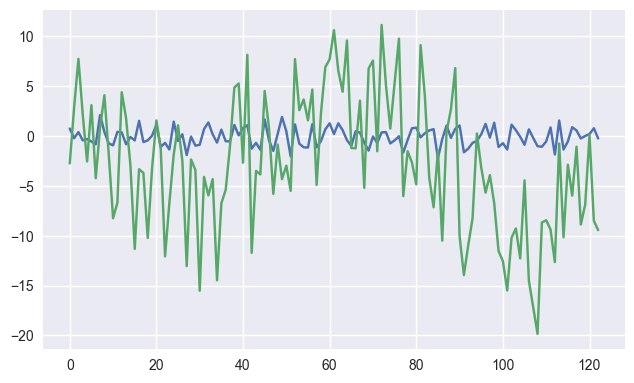

In [270]:
# to see relative relation
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["BLKA_AWAY"].as_matrix()
         )
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["AVG_SPREAD"].as_matrix()
         )

In [271]:
# Doing PCA on X both W/L and Spread
from sklearn.decomposition import PCA

X_DC = PCA(whiten=False)
X_train_PCA = X_DC.fit_transform(X_train)

X_DC_s = PCA(whiten=False)
X_train_spread_PCA = X_DC_s.fit_transform(X_train_spread)

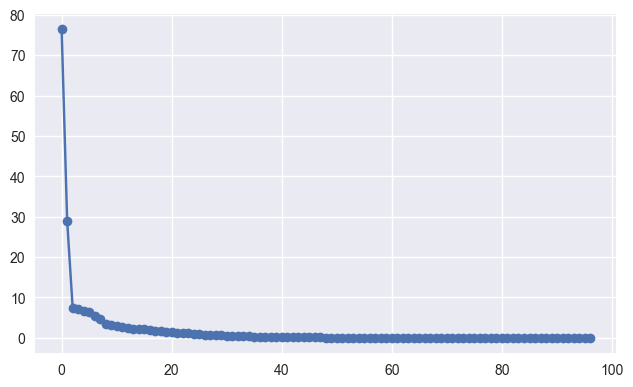

In [272]:
plt.plot(X_DC.explained_variance_, marker='o')

In [273]:
# Keeping only the first few principle components
components_keep = 5
X_train_PCA_keep = X_train_PCA[:,0:components_keep]
X_val_PCA_keep = X_DC.transform(X_val)[:,0:components_keep]
X_test_PCA_keep = X_DC.transform(X_test)[:,0:components_keep]

X_train_spread_PCA_keep = X_train_spread_PCA[:,0:components_keep]
X_val_spread_PCA_keep = X_DC_s.transform(X_val_spread)[:,0:components_keep]
X_test_spread_PCA_keep = X_DC_s.transform(X_test_spread)[:,0:components_keep]

In [274]:
# Train with only the first few PC
SVM_PCA = svm(C=0.1,penalty='l2',loss='hinge') # was C = 0.004
SVM_PCA.fit(X_train_PCA_keep,np.sign(y_train).reshape(-1))

print 'SVM validation with PCA:', (SVM_PCA.predict(X_val_PCA_keep) == np.sign(y_val).reshape(-1)).astype(int).mean()
print 'SVM test with PCA:', (SVM_PCA.predict(X_test_PCA_keep) == np.sign(y_test).reshape(-1)).astype(int).mean()

SVM validation with PCA: 0.691869918699
SVM test with PCA: 0.647154471545


In [275]:
lasso_s.fit(X_train_PCA_keep, y_train)

print 'Lasso (SPREAD) VALIDATE:', fraction_correct(lasso_s.predict(X_val_PCA_keep), y_val.ravel())
print 'Lasso (SPREAD) TEST:', fraction_correct(lasso_s.predict(X_test_PCA_keep), y_test.ravel())

Lasso (SPREAD) VALIDATE: 0.493495934959
Lasso (SPREAD) TEST: 0.506504065041


VAL XGBoost Regression winner accuracy:  0.673983739837
TEST XGBoost Regression winner accuracy:  0.638211382114


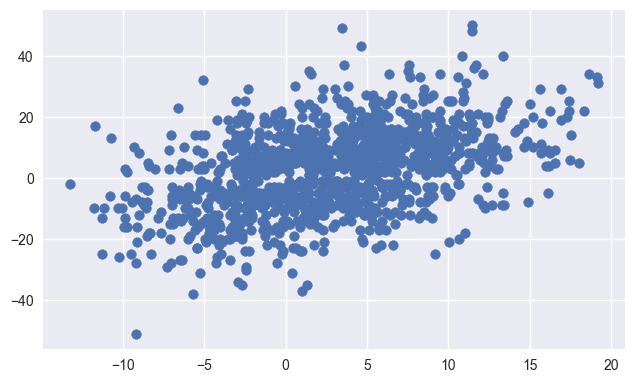

In [276]:
xgb_reg.fit(X_train_PCA_keep, y_train)
plt.scatter(xgb_reg.predict(X_val_PCA_keep), y_val)
mean_squared_error(xgb_reg.predict(X_val_PCA_keep), y_val)
print "VAL XGBoost Regression winner accuracy: ", (np.sign(xgb_reg.predict(X_val_PCA_keep)).ravel() == np.sign(y_val.ravel())).astype(float).mean()
print "TEST XGBoost Regression winner accuracy: ", (np.sign(xgb_reg.predict(X_test_PCA_keep)).ravel() == np.sign(y_test.ravel())).astype(float).mean()

In [277]:
lasso.fit(X_train_PCA_keep, y_train)
print "VAL Lasso Regression accuracy: ", (np.sign(lasso.predict(X_val_PCA_keep)).ravel() == np.sign(y_val.ravel())).astype(float).mean()
print "TEST Lasso Regression accuracy: ", (np.sign(lasso.predict(X_test_PCA_keep)).ravel() == np.sign(y_test.ravel())).astype(float).mean()

VAL Lasso Regression accuracy:  0.690243902439
TEST Lasso Regression accuracy:  0.644715447154


In [ ]:
# Train with only the first few PC
SVM_spread_PCA = svm(C=0.1,penalty='l2',loss='hinge')
SVM_spread_PCA.fit(X_train_PCA_keep,y_train_spread)
(SVM_spread_PCA.predict(X_val_spread_PCA_keep) == y_val_spread).astype(int).mean()

In [ ]:
# plot the priciple component
num = 3
plt.plot(np.arange(0,X_DC.components_.shape[1]),X_DC.components_[num,:])

In [ ]:
# See what's important element in the compenents
first_pca_feature = np.where(np.abs(X_DC.components_[num,:]) > 0.15)
df_train[numerical_cols].keys()[first_pca_feature]

## Summary of Results

In [ ]:
print "BASELINE = ", frac_wins_predicted(df['AVG_SPREAD'], df['ACTUAL_SPREAD']), "\n"

print "LINEAR REGRESSION"
print "Fraction TRAIN winner predicted correct: ", frac_wins_predicted(y_train_pred, y_train)
print "Fraction VALIDATE winner predicted correct: ", frac_wins_predicted(linreg.predict(X_val), y_val)
print "Fraction TEST winner predicted correct: ", frac_wins_predicted(linreg.predict(X_test), y_test), "\n"

print "LASSO"
lasso.fit(X_train, y_train)
print "Fraction TRAIN winner predicted correct: ", frac_wins_predicted(y_train_pred, y_train.ravel())
print "Fraction VALIDATE winner predicted correct: ", frac_wins_predicted(lasso.predict(X_val), y_val.ravel())
print "Fraction TEST winner predicted correct: ", frac_wins_predicted(lasso.predict(X_test), y_test.ravel()), "\n"

print "RANDOM FOREST"
print "TRAIN Percent wins correct:", frac_wins_predicted(y_train_pred, y_train.ravel())
print "VALIDATE Percent wins correct:", frac_wins_predicted(rf.predict(X_val), y_val.ravel())
print "TEST Percent wins correct:", frac_wins_predicted(rf.predict(X_test), y_test.ravel()), "\n"

print "XGBOOST REGRESSION"
xgb_reg.fit(X_train, y_train)
print "TRAIN Percent wins correct:", frac_wins_predicted(y_train_predict, y_train.ravel())
print "VALIDATE Percent wins correct:", frac_wins_predicted(xgb_reg.predict(X_val), y_val.ravel())
print "TEST Percent wins correct:", frac_wins_predicted(xgb_reg.predict(X_test), y_test.ravel()), "\n"

print "XGBoost Classifier"
print "TRAIN % of correctly predicted wins = ", (xgb_cls.predict(X_train).astype(int) == 0.5*(1+np.sign(y_train).ravel())).mean()
print "VALIDATE % of correctly predicted wins = ", (xgb_cls.predict(X_val).astype(int) == 0.5*(1+np.sign(y_val).ravel())).mean()
print "TEST % of correctly predicted wins = ", (xgb_cls.predict(X_test).astype(int) == 0.5*(1+np.sign(y_test).ravel())).mean(), "\n"

print "LOGISTIC REGRESSION"
print "Predicted (training) wins correct: ", frac_wins_predicted(LogR.predict(X_train), y_train.ravel())
print "Predicted (validation) wins correct: ", frac_wins_predicted(LogR.predict(X_val), y_val.ravel())
print "Predicted (test) wins correct: ", frac_wins_predicted(LogR.predict(X_test), y_test.ravel()), "\n"

print "SVM"
cs = [0.01,0.1,1,10]
for c in cs:
    SVM = svm(C=c,penalty='l2',loss='hinge')
    SVM.fit(X_train, np.sign(y_train).reshape(-1)) # y_train is the actual spread, np.sign(y_train) => home team win=1, loss=-1
    num_correct_train = (SVM.predict(X_train) == np.sign(y_train).reshape(-1)).astype(int).mean()
    print 'TRAIN c = ', c, num_correct_train
    num_correct_val = (SVM.predict(X_val) == np.sign(y_val).reshape(-1)).astype(int).mean()
    print 'VAL c = ', c, num_correct_val
    num_correct_test = (SVM.predict(X_test) == np.sign(y_test).ravel()).astype(int).mean()
    print 'TEST c = ', c, num_correct_test
    print ''

print "\n OPTIMIZATION"
print "PCA (SVM)"
print 'SVM validation with PCA:', (SVM_PCA.predict(X_val_PCA_keep) == np.sign(y_val).reshape(-1)).astype(int).mean()
print 'SVM test with PCA:', (SVM_PCA.predict(X_test_PCA_keep) == np.sign(y_test).reshape(-1)).astype(int).mean(), "\n"

print "PCA (XGBOOST_REGRESSION)"
xgb_reg.fit(X_train_PCA_keep, y_train)
print "VAL XGBoost Regression winner accuracy: ", (np.sign(xgb_reg.predict(X_val_PCA_keep)).ravel() == np.sign(y_val.ravel())).astype(float).mean()
print "TEST XGBoost Regression winner accuracy: ", (np.sign(xgb_reg.predict(X_test_PCA_keep)).ravel() == np.sign(y_test.ravel())).astype(float).mean(), "\n"

print "PCA (LASSO)"
lasso.fit(X_train_PCA_keep, y_train)
print "VAL Lasso Regression accuracy: ", (np.sign(lasso.predict(X_val_PCA_keep)).ravel() == np.sign(y_val.ravel())).astype(float).mean()
print "TEST Lasso Regression accuracy: ", (np.sign(lasso.predict(X_test_PCA_keep)).ravel() == np.sign(y_test.ravel())).astype(float).mean(), "\n"
 
print "RIGHT_WRONG"
SVM_less_features = svm(C=0.005,loss="hinge")
SVM_less_features.fit(X_train_less,np.sign(y_train).reshape(-1))
print 'TOP R-W VALIDATE:', (SVM_less_features.predict(X_val_less) == np.sign(y_val).reshape(-1)).astype(float).mean()
print 'TOP R-W TEST', (SVM_less_features.predict(X_test_less) == np.sign(y_test).reshape(-1)).astype(float).mean()

In [ ]:
# Using kernels after PCA
from sklearn.svm import SVC
kernel_svm = SVC(C=0.9,kernel = "rbf")
kernel_svm.fit(X_train_spread_PCA_keep,y_train_spread)

In [ ]:
(kernel_svm.predict(X_val_spread_PCA_keep)==y_val_spread).astype(int).mean()

In [ ]:
# Plot how prnciple component makes the problem more separable

x1_plus = X_train_PCA_keep[:,0][np.sign(y_train).reshape(-1)>=0]
x2_plus = X_train_PCA_keep[:,1][np.sign(y_train).reshape(-1)>=0]
x1_minus = X_train_PCA_keep[:,0][np.sign(y_train).reshape(-1)<0]
x2_minus = X_train_PCA_keep[:,1][np.sign(y_train).reshape(-1)<0]
plt.scatter(x1_plus,x2_plus,marker="+",c="b")
plt.scatter(x1_minus,x2_minus,marker=".",c="r")
plt.show()

In [ ]:
# comparision
x1_plus = X_train[:,0][np.sign(y_train).reshape(-1)>=0]
x2_plus = X_train[:,1][np.sign(y_train).reshape(-1)>=0]
x1_minus = X_train[:,0][np.sign(y_train).reshape(-1)<0]
x2_minus = X_train[:,1][np.sign(y_train).reshape(-1)<0]
plt.scatter(x1_plus,x2_plus,marker="+",c="b")
plt.scatter(x1_minus,x2_minus,marker=".",c="r")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_spread = RandomForestClassifier(max_depth=10,max_features="sqrt")
rf_spread.fit(X_train_spread,y_train_spread)
(rf_spread.predict(X_train_spread)==y_train_spread).astype(int).mean()